In [1]:
import pandas as pd
import numpy as np
import talib
import lightgbm as lgb
import matplotlib.pyplot as plt
import pickle
import time

In [2]:
def load_data(file_names):
    dfs = []
    for file_name in file_names:
        df = pd.read_csv(file_name, index_col="date")
        dfs.append(df)
    return dfs

In [3]:
if __name__ == "__main__":
    start_time = time.time() 
    print(start_time)

    file_names = ["test_combined_data.csv"]
    dfs = load_data(file_names)

1686396968.844419


In [4]:
df = dfs[0]
df.index = pd.to_datetime(df.index) # ensure that index is datetime
print(df)

                       open    high     low   close
date                                               
2023-04-03 07:00:00  4130.3  4132.3  4128.5  4128.9
2023-04-03 07:01:00  4128.9  4130.0  4127.0  4128.6
2023-04-03 07:02:00  4128.7  4129.3  4128.0  4128.4
2023-04-03 07:03:00  4128.4  4129.3  4127.0  4129.2
2023-04-03 07:04:00  4129.5  4132.0  4129.5  4130.4
...                     ...     ...     ...     ...
2023-06-01 05:10:00  4187.9  4188.7  4187.9  4188.7
2023-06-01 05:11:00  4188.7  4189.2  4187.7  4188.1
2023-06-01 05:12:00  4188.1  4189.2  4188.0  4188.0
2023-06-01 05:13:00  4187.9  4188.7  4187.8  4188.4
2023-06-01 05:14:00  4188.4  4189.0  4188.0  4188.8

[56790 rows x 4 columns]


In [5]:
# feature engineering
def feature_engineering(df):
    open = df['open'].values
    high = df['high'].values
    low = df['low'].values
    close = df['close'].values
    # volume = df['volume'].values
    hilo = (high + low) / 2

    df['RSI8'] = talib.RSI(close, timeperiod=8) # default = 14
    df['RSI14'] = talib.RSI(close, timeperiod=14)
    df['RSI_ST'] = talib.RSI(close)/close
    df['RSI_LOG'] = log_transform_feature(talib.RSI(close))
    df['MACD'], _, _ = talib.MACD(close)
    df['MACD_ST'], _, _ = talib.MACD(close)/close
    df['ATR'] = talib.ATR(high, low, close)
    
    df['ADX'] = talib.ADX(high, low, close, timeperiod=14)
    df['ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
    df['+DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
    df['-DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
    
    df['SMA15'] = talib.SMA(close, timeperiod=15) # 15分足
    df['SMA300'] = talib.SMA(close, timeperiod=300) # 15分足20MA
    
    df['BB_UPPER'], df['BB_MIDDLE'], df['BB_LOWER'] = talib.BBANDS(close, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    df['BBANDS_upperband'] = (df['BB_UPPER'] - hilo) / close
    df['BBANDS_middleband'] = (df['BB_MIDDLE'] - hilo) / close
    df['BBANDS_lowerband'] = (df['BB_LOWER'] - hilo) / close

    df['STOCH_K'], df['STOCH_D'] = talib.STOCH(high, low, close)/close
    df['MON'] = talib.MOM(close, timeperiod=5)

    df['pinbar'] = pinbar(df)
    df['RCI9'] = df['close'].rolling(9).apply(calc_rank_correlation)
    df['RCI26'] = df['close'].rolling(26).apply(calc_rank_correlation)
    df['RCI52'] = df['close'].rolling(52).apply(calc_rank_correlation)

    df = df.fillna(method='ffill')

    return df

def calc_rank_correlation(series):
    n = len(series)
    ranks = series.rank()
    sum_diffs_squared = sum((ranks - np.arange(n) - 1) ** 2)
    return 1 - 6 * sum_diffs_squared / (n * (n ** 2 - 1))

def log_transform_feature(X):
    X[X <= 0] = np.finfo(float).eps
    return np.log(X)

def pinbar(df):
    body = np.abs(df['close'] - df['open'])
    upper_wick = df['high'] - np.max(df[['open', 'close']], axis=1)
    lower_wick = np.min(df[['open', 'close']], axis=1) - df['low']
    total_length = df['high'] - df['low']
    
    # 上向きのピンバー（ロングサイン）:下ワックが本体の3倍以上、上ワックが全体の長さの20~30%以内
    is_bullish_pinbar = (lower_wick >= 3 * body) & (upper_wick <= total_length * 0.3)
    
    # 下向きのピンバー（ショートサイン）:上ワックが本体の3倍以上、下ワックが全体の長さの20~30%以内
    is_bearish_pinbar = (upper_wick >= 3 * body) & (lower_wick <= total_length * 0.3)
    
    # 上向きピンバー = 1、下向きピンバー = 2、ピンバーでない = 0
    return np.where(is_bullish_pinbar, 1, np.where(is_bearish_pinbar, 2, 0))

In [6]:
df = feature_engineering(df)
# df = create_price_change_ratio(df, 15)
display(df)

open    high     low   close       RSI8      RSI14   
date                                                                        
2023-04-03 07:00:00  4130.3  4132.3  4128.5  4128.9        NaN        NaN  \
2023-04-03 07:01:00  4128.9  4130.0  4127.0  4128.6        NaN        NaN   
2023-04-03 07:02:00  4128.7  4129.3  4128.0  4128.4        NaN        NaN   
2023-04-03 07:03:00  4128.4  4129.3  4127.0  4129.2        NaN        NaN   
2023-04-03 07:04:00  4129.5  4132.0  4129.5  4130.4        NaN        NaN   
...                     ...     ...     ...     ...        ...        ...   
2023-06-01 05:10:00  4187.9  4188.7  4187.9  4188.7  41.546910  40.852742   
2023-06-01 05:11:00  4188.7  4189.2  4187.7  4188.1  38.431587  39.248015   
2023-06-01 05:12:00  4188.1  4189.2  4188.0  4188.0  37.890416  38.973238   
2023-06-01 05:13:00  4187.9  4188.7  4187.8  4188.4  41.646741  40.759822   
2023-06-01 05:14:00  4188.4  4189.0  4188.0  4188.8  45.419296  42.570424   

                       RSI_ST   RSI_LOG      MACD   MACD_ST  ...  BB_MIDDLE   
date                                                         ...              
2023-04-03 07:00:00       NaN       NaN       NaN       NaN  ...        NaN  \
2023-04-03 07:01:00       NaN       NaN       NaN       NaN  ...        NaN   
2023-04-03 07:02:00       NaN       NaN       NaN       NaN  ...        NaN   
2023-04-03 07:03:00       NaN       NaN       NaN       NaN  ...        NaN   
2023-04-03 07:04:00       NaN       NaN       NaN       NaN  ...        NaN   
...                       ...       ...       ...       ...  ...        ...   
2023-06-01 05:10:00  0.009753  3.709974 -1.817972 -0.000434  ...   4190.520   
2023-06-01 05:11:00  0.009371  3.669901 -1.793274 -0.000428  ...   4190.180   
2023-06-01 05:12:00  0.009306  3.662875 -1.761464 -0.000421  ...   4189.880   
2023-06-01 05:13:00  0.009732  3.707697 -1.684560 -0.000402  ...   4189.685   
2023-06-01 05:14:00  0.010163  3.751160 -1.573201 -0.000376  ...   4189.520   

                        BB_LOWER  BBANDS_upperband  BBANDS_middleband   
date                                                                    
2023-04-03 07:00:00          NaN               NaN                NaN  \
2023-04-03 07:01:00          NaN               NaN                NaN   
2023-04-03 07:02:00          NaN               NaN                NaN   
2023-04-03 07:03:00          NaN               NaN                NaN   
2023-04-03 07:04:00          NaN               NaN                NaN   
...                          ...               ...                ...   
2023-06-01 05:10:00  4186.277548          0.001543           0.000530   
2023-06-01 05:11:00  4186.323784          0.001334           0.000413   
2023-06-01 05:12:00  4186.338475          0.001151           0.000306   
2023-06-01 05:13:00  4186.270750          0.001158           0.000343   
2023-06-01 05:14:00  4186.273710          0.001018           0.000244   

                     BBANDS_lowerband   STOCH_K   STOCH_D  MON  pinbar   
date                                                                     
2023-04-03 07:00:00               NaN       NaN       NaN  NaN       0  \
2023-04-03 07:01:00               NaN       NaN       NaN  NaN       0   
2023-04-03 07:02:00               NaN       NaN       NaN  NaN       0   
2023-04-03 07:03:00               NaN       NaN       NaN  NaN       0   
2023-04-03 07:04:00               NaN       NaN       NaN  NaN       0   
...                               ...       ...       ...  ...     ...   
2023-06-01 05:10:00         -0.000483  0.009816  0.009757  0.1       0   
2023-06-01 05:11:00         -0.000508  0.007478  0.008910 -0.4       0   
2023-06-01 05:12:00         -0.000540  0.007340  0.008212 -0.5       2   
2023-06-01 05:13:00         -0.000473  0.007074  0.007297 -0.3       0   
2023-06-01 05:14:00         -0.000531  0.011141  0.008518  0.9       0   

                          RCI  
date                           
2023-04-03 07:00

In [7]:
print(df.columns)

Index(['open', 'high', 'low', 'close', 'RSI8', 'RSI14', 'RSI_ST', 'RSI_LOG',
       'MACD', 'MACD_ST', 'ATR', 'ADX', 'ADXR', '+DI', '-DI', 'SMA15',
       'SMA300', 'BB_UPPER', 'BB_MIDDLE', 'BB_LOWER', 'BBANDS_upperband',
       'BBANDS_middleband', 'BBANDS_lowerband', 'STOCH_K', 'STOCH_D', 'MON',
       'pinbar', 'RCI'],
      dtype='object')


In [8]:
model_path = "model/multi_1m_model.pkl"
try:
    with open(model_path, "rb") as f:
        model = pickle.load(f)
    print("Model loaded successfully")
except Exception as e:
    print(f"Failed to load the model. The error is: {e}")

Model loaded successfully


In [18]:
def summarize_trade_results(trade_results):
    num_trades = len(trade_results['profits'])
    num_wins = sum(1 for x in trade_results['profits'] if x > 0)
    num_losses = num_trades - num_wins

    total_return = sum(trade_results['profits'])

    average_win = sum(x for x in trade_results['profits'] if x > 0) / num_wins if num_wins > 0 else 0
    average_loss = sum(x for x in trade_results['profits'] if x < 0) / num_losses if num_losses > 0 else 0

    profit_factor = -average_win / average_loss if average_loss != 0 else 0

    long_win_rate = sum(1 for x in trade_results['long_profits'] if x > 0) / len(trade_results['long_profits']) if trade_results['long_profits'] else 0
    short_win_rate = sum(1 for x in trade_results['short_profits'] if x > 0) / len(trade_results['short_profits']) if trade_results['short_profits'] else 0

    # Create cumulative return series
    cumulative_returns = np.cumsum(trade_results['profits'])
    cumulative_long_returns = np.cumsum(trade_results['long_profits'])
    cumulative_short_returns = np.cumsum(trade_results['short_profits'])

    # Calculate maximum drawdown using numpy
    cumulative_max = np.maximum.accumulate(cumulative_returns)
    non_zero_max = cumulative_max > 0
    drawdowns = np.full_like(cumulative_returns, fill_value=0)
    drawdowns[non_zero_max] = 1 - cumulative_returns[non_zero_max] / cumulative_max[non_zero_max]
    max_drawdown = np.max(drawdowns)
    maximum_single_trade_loss = min(trade_results['profits']) if trade_results['profits'] else 0

    # Print the statistics
    print(f"Total Return: {total_return:.2f}")
    print(f"Total Trade Num: {len(trade_results['profits'])}")
    print(f"Max Drawdown: {max_drawdown * 100:.2f}%")
    print(f"Max Single Trade Loss: {maximum_single_trade_loss:.2f}")
    print(f"Profit Factor: {profit_factor:.2f}")
    print(f"Long Trade Num: {len(trade_results['long_profits'])}")
    print(f"Long Win Rate: {long_win_rate * 100:.2f}%")
    print(f"Short Trade Num: {len(trade_results['short_profits'])}")
    print(f"Short Win Rate: {short_win_rate * 100:.2f}%")

    print(f"Take Profit: {len(trade_results['take_profit'])}")
    print(f"Stop Loss: {len(trade_results['stop_loss'])}")

    # Plot the results
    plt.figure(figsize=(10,6))
    plt.plot(cumulative_returns, label='Total Returns')
    plt.title("Cumulative Total Returns")
    plt.xlabel("Trade")
    plt.ylabel("Cumulative Return")
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(10,6))
    plt.plot(cumulative_long_returns, label='Long Returns', color='blue')
    plt.plot(cumulative_short_returns, label='Short Returns', color='red')
    plt.title("Cumulative Long and Short Returns")
    plt.xlabel("Trade")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid(True)
    plt.show()

In [19]:
def initPortfolio():
    portfolio = {
        'position': None,  # "long" or "short"
        'entry_price': None,
        'entry_point': 0,
        'stop_loss': 0,
        'take_profit': 0
    }
    return portfolio

/Users/tek/dev/python/gmo-algo-trading/myenv/lib/python3.11/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
/Users/tek/dev/python/gmo-algo-trading/myenv/lib/python3.11/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
/Users/tek/dev/python/gmo-algo-trading/myenv/lib/python3.11/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
/Users/tek/dev/python/gmo-algo-trading/myenv/lib/python3.11/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')
/Users/tek/dev/python/gmo-algo-trading/myenv/lib/python3.11/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Co

Total Return: 0.00
Total Trade Num: 56490
Max Drawdown: 0.00%
Max Single Trade Loss: 0.00
Profit Factor: 0.00
Long Trade Num: 0
Long Win Rate: 0.00%
Short Trade Num: 0
Short Win Rate: 0.00%
Take Profit: 0
Stop Loss: 0


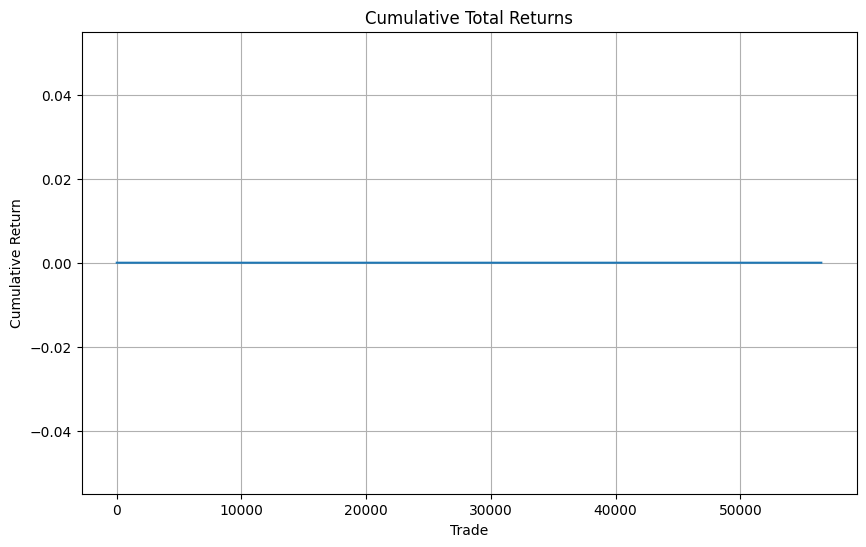

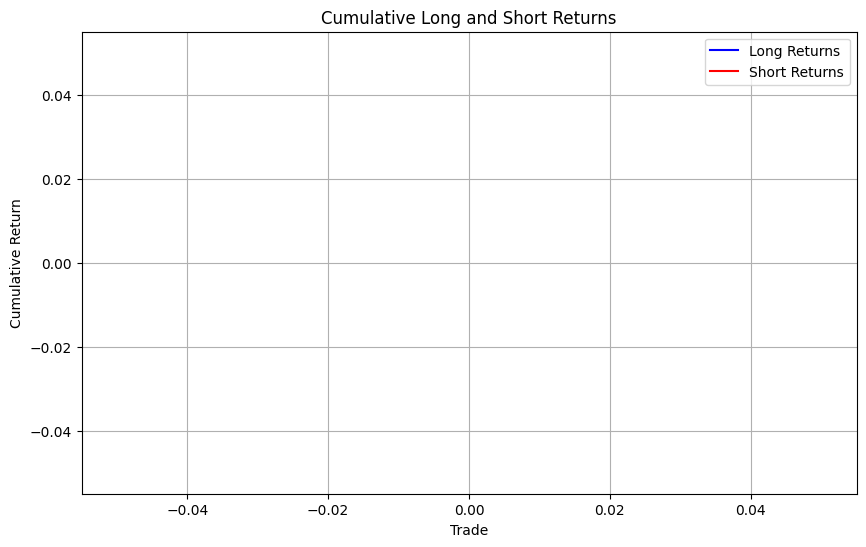

In [32]:
# Initialize trade_results
trade_results = {
    'profits': [],
    'long_profits': [],
    'short_profits': [],
    'take_profit': [],
    'stop_loss': [],
}

# Initialize portfolio state
portfolio = initPortfolio()

# Define helper function for large bullish and bearish candle
def large_bullish_candle(row, df, i):
    return (row['close'] - row['open']) > df['close'].iloc[i-200:i].quantile(0.7)

def large_bearish_candle(row, df, i):
    return (row['open'] - row['close']) > df['close'].iloc[i-200:i].quantile(0.7)

# Loop through the data
for i in range(300, len(df)):  # Start from index 300 because of sma300
    profit = 0

    # Get the current row of data
    data_row = df.iloc[i]
    prev_row = df.iloc[i-1]

    y_pred = model.predict(data_row)
    
    # Determine the market trend
    up_trend = data_row['SMA15'] > data_row['SMA300'] and data_row['SMA15'] > df['SMA15'].iloc[i-1]
    down_trend = data_row['SMA15'] < data_row['SMA300'] and data_row['SMA15'] < df['SMA15'].iloc[i-1]

    # Close position
    if portfolio['position'] is not None:
        if portfolio['position'] == 'long':
            if data_row['low'] <= portfolio['stop_loss'] or data_row['high'] >= portfolio['take_profit']:
                profit = data_row['close'] - portfolio['entry_price']
                trade_results['profits'].append(profit)
                trade_results['long_profits'].append(profit)
                portfolio = initPortfolio()

                if data_row['low'] <= portfolio['stop_loss']:
                    trade_results['stop_loss'].append(1)
                elif data_row['high'] >= portfolio['take_profit']:
                    trade_results['take_profit'].append(1)

        elif portfolio['position'] == 'short':
            if data_row['high'] >= portfolio['stop_loss'] or data_row['low'] <= portfolio['take_profit']:
                profit = portfolio['entry_price'] - data_row['close'] 
                trade_results['profits'].append(profit)
                trade_results['short_profits'].append(profit)
                portfolio = initPortfolio()

                if data_row['high'] >= portfolio['stop_loss']:
                    trade_results['stop_loss'].append(1)
                elif data_row['low'] <= portfolio['take_profit']:
                    trade_results['take_profit'].append(1)

        else:
            trade_results['profits'].append(0)

    # Open position
    else:
        # Long Entry
        if up_trend and large_bullish_candle(df.iloc[i-1], df, i):  # large bullish candle appears
            trade_results['profits'].append(0)
            portfolio = {
                'position': 'long',
                'entry_price': data_row['close'],
                'stop_loss': df['close'].iloc[i-15:i].min(),
                'take_profit': data_row['close'] + 1 * (data_row['close'] - df['close'].iloc[i-15:i].min())
            }

        # Short Entry
        # Short Entry
        if down_trend and large_bearish_candle(df.iloc[i-1], df, i):  # large bearish candle appears
            trade_results['profits'].append(0)
            portfolio = {
                'position': 'short',
                'entry_price': data_row['close'],
                'stop_loss': df['close'].iloc[i-15:i].max(),
                'take_profit': data_row['close'] - 1 * (df['close'].iloc[i-15:i].max() - data_row['close'])
            }

        else:
            trade_results['profits'].append(0)

summarize_trade_results(trade_results)